In [13]:
import requests
import pandas as pd
import time
import math
from pathlib import Path
from pandas.io.parsers import read_csv
from google.colab import drive
import json

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


JUNTAR TODOS LOS DATOS Y FILTRAR


In [14]:
d1 = read_csv('/content/drive/MyDrive/PD1/d_17_02.csv', header=0)
d2 = read_csv('/content/drive/MyDrive/PD1/d_1_03.csv', header=0)
d3 = read_csv('/content/drive/MyDrive/PD1/d_21_02.csv', header=0)
d4 = read_csv('/content/drive/MyDrive/PD1/d_26_02.csv', header=0)
d5 = read_csv('/content/drive/MyDrive/PD1/d_28_02.csv', header=0)
d6 = read_csv('/content/drive/MyDrive/PD1/datos_5_03.csv', header=0)

In [48]:
# Juntar todos los dataframes en uno solo
df_total = pd.concat([d1, d2, d3, d4, d5, d6], ignore_index=True)
print(len(df_total))

# Contar las filas que están duplicadas
num_duplicados = df_total.duplicated().sum()
print("Filas duplicadas", num_duplicados)

# Eliminar los duplicados del dataframe (inplace=True para que los elimine sobre el propio dataframe)
df_total.drop_duplicates(inplace=True)
print('Num filas sin duplicados', len(df_total))

df_total = df_total.drop(columns = ['id', 'test', 'url','images', 'promoters',
                                    'type', 'locale', '_links', 'seatmap'])

5129
Filas duplicadas 2637
Num filas sin duplicados 2492


In [ ]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2492 entries, 0 to 5128
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             2492 non-null   object
 1   sales            2492 non-null   object
 2   dates            2492 non-null   object
 3   classifications  2492 non-null   object
 4   promoter         2489 non-null   object
 5   priceRanges      2483 non-null   object
 6   _links           2492 non-null   object
 7   _embedded        2492 non-null   object
dtypes: object(8)
memory usage: 175.2+ KB


In [49]:
# lista de strings a filtrar
strings_filtrar = ['film', 'servicio de autobús', 'festival', 'vip', 'meet', 'meet & greet', 'ticket', 'package', 'musical']

# Filtrar
for string in strings_filtrar:
    df_total = df_total[~df_total['name'].str.lower().str.contains(string)]

print(len(df_total))

1911


In [ ]:
df_total.sample(5)

,name,sales,dates,classifications,promoter,priceRanges,_links,_embedded
139,Depeche Mode - Memento Mori Tour,{'public': {'startDateTime': '2023-07-19T08:00...,"{'start': {'localDate': '2024-03-12', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '6083', 'name': 'Live Nation España Blu...","[{'type': 'standard including fees', 'currency...",{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'WiZink Center', 'type': ..."
1106,Luis Miguel,{'public': {'startDateTime': '2023-12-04T09:00...,"{'start': {'localDate': '2024-07-27', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '6269', 'name': 'Luciérnagas en mi vent...","[{'type': 'standard including fees', 'currency...",{'self': {'href': '/discovery/v2/events/Z698xZ...,{'venues': [{'name': 'Estadi Ciutat de Valènci...
458,Pink Turns Blue + Hørd,{'public': {'startDateTime': '2023-10-18T16:30...,{'access': {'startDateTime': '2024-04-18T20:00...,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '2761', 'name': 'Sergio Solís Gálvez'}","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'self': {'href': '/discovery/v2/events/Z698xZ...,{'venues': [{'name': 'Sala Upload - Poble Espa...
760,Ants,{'public': {'startDateTime': '2024-02-14T17:30...,"{'start': {'localDate': '2024-10-05', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5895', 'name': 'Only Tickets, S.L.,'}","[{'type': 'standard including fees', 'currency...",{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'Ushuaïa Ibiza', 'type': ..."
934,Enol,{'public': {'startDateTime': '2023-10-17T10:00...,{'access': {'startDateTime': '2024-04-14T20:00...,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '2771', 'name': 'Promociones Musicales ...","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'self': {'href': '/discovery/v2/events/Z698xZ...,"{'venues': [{'name': 'La Riviera', 'type': 've..."


Una vez eliminados algunos eventos por el nombre subdividimos las columnas que tenemos. Sin embargo, vemos que los valores de las filas usan comillas simples (') en vez de dobles (") y los valores booleanos en mayúsculas (False, True) en vez de minúsculas (false, true). Será necesario usar una función que corrija estos fallos y así podamos usar la función json.loads que nos permite convertir cadenas a diccionarios.





In [50]:
def corregir_json(json_str):
    # Convertir a cadena de texto si no es una cadena
    if isinstance(json_str, str):
        # Reemplazar comillas simples por comillas dobles
        corregida = json_str.replace("'", '"')
        # Reemplazar "True" por "true" y "False" por "false"
        corregida = corregida.replace("True", "true")
        corregida = corregida.replace("False", "false")
        return json.loads(corregida)
    else:
        return json_str


def corregir_columnas(df, columnas):
    for columna in columnas:
        df[columna] = df[columna].apply(corregir_json)
    return df

# Lista de columnas a corregir
columnas_a_corregir = ['sales', 'dates', 'classifications', 'promoter', 'priceRanges']

# Aplicar la función de corrección a las columnas especificadas
df_1 = corregir_columnas(df_total, columnas_a_corregir)

Usamos diferentes funciones para subdivdir las columnas.


In [ ]:
df_1.iloc[0]

name                                                    Jamie Cullum
sales              {'public': {'startDateTime': '2023-11-30T16:56...
dates              {'access': {'startDateTime': '2024-06-14T20:00...
classifications    [{'primary': True, 'segment': {'id': 'KZFzniwn...
promoter           {'id': '6253', 'name': 'Tickex Experience, S.L.'}
priceRanges        [{'type': 'standard including fees', 'currency...
_embedded          {'venues': [{'name': 'Auditorio Starlite', 'ty...
Name: 0, dtype: object

In [51]:
# Para obtener la start_datetime
def obtener_start_datetime(fila):
    if 'access' in fila['dates'] and 'startDateTime' in fila['dates']['access']:
      return fila['dates']['access']['startDateTime']
    elif 'start' in fila['dates'] and 'dateTime' in fila['dates']['start']:
      return fila['dates']['start']['dateTime']
    else:
      return None  # O un valor predeterminado que desees asignar cuando la clave no está presente

def obtener_end_datetime(fila):
    return fila['sales']['public'].get('endDateTime')

def obtener_min_price(fila):
    if 'priceRanges' in fila and isinstance(fila['priceRanges'], list) and fila['priceRanges']:
        for price_range in fila['priceRanges']:
            if price_range.get('type') == 'standard':
                return price_range['min']
    return None

def obtener_max_price(fila):
    if 'priceRanges' in fila and isinstance(fila['priceRanges'], list) and fila['priceRanges']:
        for price_range in fila['priceRanges']:
            if price_range.get('type') == 'standard':
                return price_range['max']
    return None

def obtener_promotor(fila):
    if 'promoter' in fila and isinstance(fila['promoter'], dict):
        return fila['promoter'].get('name')
    else:
        return None

def obtener_genero(fila):
    if isinstance(fila['classifications'], list) and fila['classifications']:
        # Verifica si classifications es una lista no vacía
        for item in fila['classifications']:
            if 'genre' in item and isinstance(item['genre'], dict):
                return item['genre'].get('name')
    return None

def obtener_subgenero(fila):
    if isinstance(fila['classifications'], list) and fila['classifications']:
        for item in fila['classifications']:
            if 'subGenre' in item and isinstance(item['subGenre'], dict):
                return item['subGenre'].get('name')
    return None


In [52]:
df_1['startDateTime'] = df_1.apply(obtener_start_datetime, axis=1)
df_1['end_datetime'] = df_1.apply(obtener_end_datetime, axis=1)
df_1['min_price'] = df_1.apply(obtener_min_price, axis=1)
df_1['max_price'] = df_1.apply(obtener_max_price, axis=1)
df_1['genero'] = df_1.apply(obtener_genero, axis=1)
df_1['subgnero'] = df_1.apply(obtener_subgenero, axis=1)
df_1['promoter'] = df_1.apply(obtener_promotor, axis=1)

In [53]:
df_1 = df_1.reset_index(drop=True)
df_1.sample(5)

,name,sales,dates,classifications,promoter,priceRanges,_embedded,startDateTime,end_datetime,min_price,max_price,genero,subgnero
316,Tomorrowland presents Dimitri Vegas & Like Mike,{'public': {'startDateTime': '2024-02-14T17:00...,"{'start': {'localDate': '2024-05-15', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","Only Tickets, S.L.,","[{'type': 'standard including fees', 'currency...","{'venues': [{'name': 'Ushuaïa Ibiza', 'type': ...",2024-05-15T15:00:00Z,2024-05-15T06:00:00Z,55.0,55.0,Dance/Electronic,Dance/Electronic
1726,Hozier,{'public': {'startDateTime': '2023-12-04T09:00...,"{'start': {'localDate': '2024-07-01', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...",Live Nation España S.A.U.,"[{'type': 'standard', 'currency': 'EUR', 'min'...","{'venues': [{'name': 'WiZink Center', 'type': ...",2024-07-01T19:00:00Z,2024-07-01T19:00:00Z,55.0,70.0,Rock,Pop
325,Camela,{'public': {'startDateTime': '2023-10-23T08:00...,"{'start': {'localDate': '2024-03-01', 'localTi...","[{'primary': True, 'segment': {'id': 'KZFzniwn...","Live Las Ventas, A.I.E.","[{'type': 'standard', 'currency': 'EUR', 'min'...","{'venues': [{'name': 'Live Las Ventas', 'type'...",2024-03-01T21:00:00Z,2024-03-01T21:00:00Z,30.0,55.0,Other,Other
783,El Pau,{'public': {'startDateTime': '2024-01-09T09:00...,{'access': {'startDateTime': '2024-04-19T20:00...,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","Eo Música Representación y Producción, S.L.U.","[{'type': 'standard', 'currency': 'EUR', 'min'...","{'venues': [{'name': 'Sala Universonoro', 'typ...",2024-04-19T20:00:00Z,2024-04-19T18:30:00Z,15.0,15.0,Other,Other
479,Pitingo / Soulería de ida y vuelta,{'public': {'startDateTime': '2024-01-25T08:00...,{'access': {'startDateTime': '2024-08-06T22:00...,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",Fundación Cante de las Minas,"[{'type': 'standard including fees', 'currency...",{'venues': [{'name': 'Antiguo Mercado Público'...,2024-08-06T22:00:00Z,2024-08-06T21:00:00Z,25.0,70.0,World,Flamenco


In [54]:
num_nulos = df_1['startDateTime'].isnull().sum()
num_nulos


6

In [37]:
df_1.iloc[991]['dates']

{'start': {'localDate': '2024-09-03',
  'localTime': '23:30:00',
  'dateTime': '2024-09-03T21:30:00Z',
  'dateTBD': False,
  'dateTBA': False,
  'timeTBA': False,
  'noSpecificTime': False},
 'timezone': 'Europe/Madrid',
 'status': {'code': 'onsale'},
 'spanMultipleDays': False}

In [ ]:
df_1 = df_1.drop(columns=['sales','dates','classifications','priceRanges'])

In [ ]:
df_1.sample(5)

,name,promoter,_embedded,startDateTime,end_datetime,min_price,max_price,genero,subgnero
1833,Tomorrowland presents Dimitri Vegas & Like Mike,"Only Tickets, S.L.,","{'venues': [{'name': 'Ushuaïa Ibiza', 'type': ...",None,2024-07-31T06:00:00Z,55.0,70.0,Dance/Electronic,Dance/Electronic
1149,Alice Cooper - ALMA Festival Barcelona 2024,"Concerts Studio, S.L.","{'venues': [{'name': 'Poble Espanyol', 'type':...",2024-06-28T19:00:00Z,2024-06-28T19:30:00Z,44.0,95.0,Undefined,Undefined
615,Calvin Harris,"Only Tickets, S.L.,","{'venues': [{'name': 'Ushuaïa Ibiza', 'type': ...",None,2024-06-28T06:00:00Z,100.0,100.0,Dance/Electronic,Dance/Electronic
1158,Eric Prydz,"Only Tickets, S.L.,","{'venues': [{'name': 'Hï Ibiza', 'type': 'venu...",None,2024-07-01T06:00:00Z,70.0,70.0,Dance/Electronic,Dance/Electronic
903,Camilo,"Alcanzando Metas, A.I.E.",{'venues': [{'name': 'Estadio La Cartuja de Se...,None,2024-06-28T20:00:00Z,25.0,110.0,Rock,Pop


Exploramos las nuevas columnas que hemos creado.


In [ ]:
generos = df_1['genero'].value_counts()
generos

Dance/Electronic     712
Rock                 692
Other                198
Undefined            107
Alternative           93
Hip-Hop/Rap           34
Music                 25
World                 25
Classical             11
Theatre                6
Blues                  4
Pop                    3
Fairs & Festivals      1
Name: genero, dtype: int64

In [ ]:
subgeneros = df_1['subgnero'].value_counts()
subgeneros

Dance/Electronic     712
Pop                  646
Other                198
Undefined            107
Alternative Rock      93
Hard Rock             46
Hip-Hop/Rap           34
Music                 25
Flamenco              16
Classical/Vocal       11
World                  9
Drama                  6
Jazz Blues             4
African Pop            3
Fairs & Festivals      1
Name: subgnero, dtype: int64

Es probable que no encontremos información de los oyenetes de los géneros: Classical, Theatre, Fairs & Festivals. Esta será una de nuestras variables principales por lo que al no tenerla no podremos usar estos datos como prueba.


In [ ]:
generos = ['Classical', 'Theatre', 'Fairs & Festivals']
df_1 = df_1[~df_1['genero'].isin(generos)]
len(df_1)

2468

Ahora queda subdividir la columna _embedded que se ha leido del csv como string. Necesitamos tranformarla en el diccionario que era para poder obtener más variables. Esta es una muestra de los valores que tiene:


In [ ]:
df_1.iloc[1]['_embedded']

"{'venues': [{'name': 'Auditorio Starlite', 'type': 'venue', 'id': 'Z598xZ2qZkAek', 'test': False, 'url': 'https://www.ticketmaster.es/venue/auditorio-starlite-marbella-entradas/starlitmar/114', 'locale': 'en-us', 'postalCode': '29602', 'timezone': 'Europe/Madrid', 'city': {'name': 'Marbella'}, 'state': {'name': 'Málaga'}, 'country': {'name': 'Spain', 'countryCode': 'ES'}, 'address': {'line1': 'Calle Albinoni, s/n. Cantera de Nagüeles'}, 'location': {'longitude': '-4.94999', 'latitude': '36.5266'}, 'upcomingEvents': {'mfx-es': 33, '_total': 33, '_filtered': 0}, '_links': {'self': {'href': '/discovery/v2/venues/Z598xZ2qZkAek?locale=en-us'}}}], 'attractions': [{'name': 'Sheryl Crow', 'type': 'attraction', 'id': 'K8vZ91713kV', 'test': False, 'url': 'https://www.ticketmaster.co.nz/sheryl-crow-tickets/artist/752821', 'locale': 'en-us', 'externalLinks': {'youtube': [{'url': 'https://www.youtube.com/channel/UC89Lupwwv9ANeuxfDRXo7mQ'}], 'twitter': [{'url': 'https://twitter.com/SherylCrow'}], '

Al igual que antes reemplazamos las comillas simples por comillas dobles y los valores True, False a true, false. Hacemos estas modificaciones y se lo devolvemos al dataframe con el que estamos trabajando (df_1)


In [ ]:
em = df_1['_embedded']
col = em.str.replace("'", '"')
col = col.str.replace("True", 'true')
col = col.str.replace("False", 'false')
df_1['_embedded'] = col

Ahora arreglamos el los valores de la columna _embedded en una nueva columna llamada columna_json. En caso de que sea incapaz de cargar la columna, devolverá None


In [ ]:
def load_json(json_str):
    try:
        json_object = json.loads(json_str)
        return json_object
    except json.JSONDecodeError as e:
        return None

df_1['columna_json'] = df_1['_embedded'].apply(load_json)

print('Valores None en la columna',df_1['columna_json'].isna().sum())

Valores None en la columna 699


Como usaremos las variables de la columna_json creamos un nuevo dataframe (df_2) con las filas que no tiene none en la columna_json.

In [ ]:
df_2 = df_1.dropna(subset=['columna_json'])
len(df_2)

1194

Ahora dividimos la columna_json en nuevas variables.

In [ ]:
def genre_event(fila):
    if 'columna_json' in fila and 'attractions' in fila['columna_json'] and fila['columna_json']['attractions']:
        return fila['columna_json']['attractions'][0]['classifications'][0]['genre']['name']
    else:
        return None

def subgenre_event(fila):
    if 'columna_json' in fila and 'attractions' in fila['columna_json'] and fila['columna_json']['attractions']:
        return fila['columna_json']['attractions'][0]['classifications'][0]['subGenre']['name']
    else:
        return None

def type_event(fila):
    if 'columna_json' in fila and 'attractions' in fila['columna_json'] and fila['columna_json']['attractions']:
        return fila['columna_json']['attractions'][0]['classifications'][0]['type']['name']
    else:
        return None

def subtype_event(fila):
    if 'columna_json' in fila and 'attractions' in fila['columna_json'] and fila['columna_json']['attractions']:
        return fila['columna_json']['attractions'][0]['classifications'][0]['subType']['name']
    else:
        return None

def name(fila):
    if 'columna_json' in fila and 'attractions' in fila['columna_json'] and fila['columna_json']['attractions']:
        return fila['columna_json']['attractions'][0]['name']
    else:
        return None

def venue_name(fila):
    return fila['columna_json']['venues'][0]['name']

def venue_city(fila):
  return fila['columna_json']['venues'][0]['city']['name']

def venue_state(fila):
  return fila['columna_json']['venues'][0]['state']['name']

def venue_country(fila):
  return fila['columna_json']['venues'][0]['country']['name']



In [ ]:
df_2.loc[:, 'nameArtist'] = df_2.apply(name, axis=1).copy()
df_2.loc[:, 'genre'] = df_2.apply(genre_event, axis=1).copy()
df_2.loc[:, 'subgenre'] = df_2.apply(subgenre_event, axis=1).copy()
df_2.loc[:, 'type'] = df_2.apply(type_event, axis=1).copy()
df_2.loc[:, 'subtype'] = df_2.apply(subtype_event, axis=1).copy()
df_2['VenueName'] = df_2.apply(venue_name, axis=1)
df_2['VenueCity'] = df_2.apply(venue_city, axis=1)
df_2['VenueState'] = df_2.apply(venue_state, axis=1)
df_2['VenueCountry'] = df_2.apply(venue_country, axis=1)

<ipython-input-21-796e21fc6b3d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.loc[:, 'nameArtist'] = df_2.apply(name, axis=1).copy()
<ipython-input-21-796e21fc6b3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.loc[:, 'genre'] = df_2.apply(genre_event, axis=1).copy()
<ipython-input-21-796e21fc6b3d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [ ]:
df_2 = df_2.drop(columns=['_embedded','columna_json','VenueCountry',])

In [ ]:
df_2

,name,promoter,startDateTime,end_datetime,min_price,max_price,genero,subgnero,nameArtist,genre,subgenre,type,subtype,VenueName,VenueCity,VenueState
0,Jamie Cullum,"Tickex Experience, S.L.",2024-06-14T20:00:00Z,2024-06-12T21:59:00Z,30.01,59.29,Music,Music,Jamie Cullum,Jazz,Jazz,Undefined,Undefined,Auditorio Starlite,Marbella,Málaga
1,Sheryl Crow,"Tickex Experience, S.L.",2024-06-21T20:00:00Z,2024-06-19T21:59:00Z,30.01,80.00,Music,Music,Sheryl Crow,Rock,Alternative Rock,Undefined,Undefined,Auditorio Starlite,Marbella,Málaga
2,Aitana,"Tickex Experience, S.L.",2024-06-22T20:00:00Z,2024-06-20T21:59:00Z,65.18,146.43,Music,Music,Aitana,Pop,Pop Vocal,Undefined,Undefined,Auditorio Starlite,Marbella,Málaga
3,Christian Nodal,"Tickex Experience, S.L.",2024-07-13T20:00:00Z,2024-07-11T21:59:00Z,30.01,79.29,Music,Music,Christian Nodal,World,Latin,Individual,Musician,Auditorio Starlite,Marbella,Málaga
4,Take That,"Tickex Experience, S.L.",2024-07-14T20:00:00Z,2024-07-12T21:59:00Z,55.36,155.36,Music,Music,Take That,Rock,Pop,Undefined,Undefined,Auditorio Starlite,Marbella,Málaga
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,Hombres G,"Tickex Experience, S.L.",2024-08-31T20:00:00Z,2024-08-29T21:59:00Z,39.29,127.68,Undefined,Undefined,Hombres G,Pop,Pop Rock,Group,Band,Auditorio Starlite,Marbella,Málaga
1906,Christian Nodal,"JI Entertainment, A.I.E.",2024-07-05T19:00:00Z,2024-07-05T19:00:00Z,25.00,90.00,World,World,Christian Nodal,World,Latin,Individual,Musician,WiZink Center,Madrid,Madrid
1907,The Teskey Brothers,Live Nation España S.A.U.,None,2024-07-19T19:00:00Z,30.00,30.00,Other,Other,The Teskey Brothers,Blues,Blues,Group,Band,La Riviera,Madrid,Madrid
1908,The Teskey Brothers,Live Nation España S.A.U.,None,2024-07-20T19:00:00Z,30.00,30.00,Other,Other,The Teskey Brothers,Blues,Blues,Group,Band,Sala Razzmatazz 1,Barcelona,Barcelona


In [ ]:
import requests

# Tu API key y secret obtenidos en el paso anterior
client_id = '3e082f0f2dd240c1beb66c9705a663a5'
client_secret = 'd3dd1f7886eb4ba4aa5a76c9095120d7'

# URL de la API de Spotify para obtener un token de acceso
token_url = 'https://accounts.spotify.com/api/token'

# Parámetros necesarios para obtener el token de acceso
token_params = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
}

# Obtener el token de acceso
token_response = requests.post(token_url, data=token_params)
token_data = token_response.json()

# Verificar si se obtuvo correctamente el token
if 'access_token' in token_data:
    access_token = token_data['access_token']

    # Lista de nombres de artistas
    artist_names = [i for i in df_2['nameArtist'].unique()]

    # URL de la API de Spotify para buscar al artista
    search_url = 'https://api.spotify.com/v1/search'

    # Configurar el diccionario para almacenar los IDs de los artistas
    artist_ids = {}

    # Configurar la cabecera con el token de acceso
    headers = {
        'Authorization': f'Bearer {access_token}',
    }

    # Hacer la solicitud de búsqueda del artista para cada nombre en la lista
    for artist_name in artist_names:
        search_params = {
            'q': artist_name,
            'type': 'artist',
        }

        # Hacer la solicitud de búsqueda del artista
        search_response = requests.get(search_url, params=search_params, headers=headers)
        search_data = search_response.json()

        # Verificar si se encontraron resultados para el artista en 2022
        if 'artists' in search_data and 'items' in search_data['artists']:
            for artist in search_data['artists']['items']:
                if 'name' in artist and artist['name'] == artist_name:
                    # Agregar la entrada al diccionario
                    artist_ids[artist_name] = artist['id']
                    break
            else:
                print(f"No se encontraron resultados para {artist_name} en 2022")
        else:
            print(f'No se encontró al artista {artist_name}')

    # Imprimir el diccionario resultante

else:
    print('Error al obtener el token de acceso')
    print(token_data)


No se encontraron resultados para UB40 Featuring Ali Campbell in memory of Astro en 2022
No se encontraron resultados para Ballet Flamenco Sara Baras en 2022
No se encontraron resultados para Australian Pink Floyd Show en 2022
No se encontraron resultados para Rulo y la Contrabanda en 2022
No se encontraron resultados para Dystinct en 2022
No se encontraron resultados para Vida Records & Friends en 2022
No se encontraron resultados para Álvaro de Luna en 2022
No se encontraron resultados para Pablo Rouss en 2022
No se encontró al artista None
No se encontraron resultados para Primavera Pop en 2022
No se encontraron resultados para Tan Biónica en 2022
No se encontraron resultados para MANÁ en 2022
No se encontraron resultados para gREAT sTRAITS en 2022
No se encontraron resultados para Rozalen en 2022
No se encontraron resultados para Stingers en 2022
No se encontraron resultados para Mago De Oz en 2022
No se encontraron resultados para Tributo a Queen en 2022
No se encontraron resultad

In [ ]:
df_ids= pd.DataFrame([[key, artist_ids[key]] for key in artist_ids.keys()], columns=['Name', 'Ids'])
df_ids

,Name,Ids
0,Jamie Cullum,3XxxEq6BREC57nCWXbQZ7o
1,Sheryl Crow,4TKTii6gnOnUXQHyuo9JaD
2,Aitana,7eLcDZDYHXZCebtQmVFL25
3,Christian Nodal,0XwVARXT135rw8lyw1EeWP
4,Take That,1XgFuvRd7r5g0h844A5ZUQ
...,...,...
153,Karol G,4asJQrazucWu3Zy5R7B164
154,Simple Minds,6hN9F0iuULZYWXppob22Aj
155,Ronald Borjas,1c8m6rFeA6QIhImbIaZ7k2
156,Front 242,2tyMOS8xKREgpEwHnLc6EX


In [ ]:

# Tu API key y secret obtenidos en el paso anterior
client_id = '3e082f0f2dd240c1beb66c9705a663a5'
client_secret = 'd3dd1f7886eb4ba4aa5a76c9095120d7'

# URL de la API de Spotify para obtener un token de acceso
token_url = 'https://accounts.spotify.com/api/token'

# Parámetros necesarios para obtener el token de acceso
token_params = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
}

# Obtener el token de acceso
token_response = requests.post(token_url, data=token_params)
token_data = token_response.json()

# Verificar si se obtuvo correctamente el token
if 'access_token' in token_data:
    access_token = token_data['access_token']

    # DataFrame con la columna de IDs de los artistas
    df_artist_ids = pd.DataFrame({'Ids': df_ids['Ids']})

    # URL base de la API de Spotify para obtener información de varios artistas
    artists_url = 'https://api.spotify.com/v1/artists'

    # Configurar la cabecera con el token de acceso
    headers = {
        'Authorization': f'Bearer {access_token}',
    }

    # Lista para almacenar los números de oyentes de cada artista
    followers_counts = []

    # Hacer la solicitud para obtener información de cada artista
    for artist_id in df_artist_ids['Ids']:
        artist_url = f'{artists_url}/{artist_id}'
        artist_response = requests.get(artist_url, headers=headers)
        artist_data = artist_response.json()

        # Verificar si se obtuvo correctamente la información del artista
        if 'followers' in artist_data:
            followers_count = artist_data['followers']['total']
            followers_counts.append(followers_count)
        else:
            followers_counts.append(None)  # Si no se encuentra el número de oyentes, agregar None

    # Agregar la columna de números de oyentes al DataFrame
    df_artist_ids['followers_count'] = followers_counts

    # Mostrar el DataFrame resultante

else:
    print('Error al obtener el token de acceso')
    print(token_data)

df_artist_ids

,Ids,followers_count
0,3XxxEq6BREC57nCWXbQZ7o,514905
1,4TKTii6gnOnUXQHyuo9JaD,1119957
2,7eLcDZDYHXZCebtQmVFL25,2898099
3,0XwVARXT135rw8lyw1EeWP,14130881
4,1XgFuvRd7r5g0h844A5ZUQ,1278678
...,...,...
153,4asJQrazucWu3Zy5R7B164,3549
154,6hN9F0iuULZYWXppob22Aj,1935158
155,1c8m6rFeA6QIhImbIaZ7k2,106030
156,2tyMOS8xKREgpEwHnLc6EX,139712


In [ ]:
df_ids['Oyentes Mensuales']=df_artist_ids['followers_count']
df_ids

,Name,Ids,Oyentes Mensuales
0,Jamie Cullum,3XxxEq6BREC57nCWXbQZ7o,514905
1,Sheryl Crow,4TKTii6gnOnUXQHyuo9JaD,1119957
2,Aitana,7eLcDZDYHXZCebtQmVFL25,2898099
3,Christian Nodal,0XwVARXT135rw8lyw1EeWP,14130881
4,Take That,1XgFuvRd7r5g0h844A5ZUQ,1278678
...,...,...,...
153,Karol G,4asJQrazucWu3Zy5R7B164,3549
154,Simple Minds,6hN9F0iuULZYWXppob22Aj,1935158
155,Ronald Borjas,1c8m6rFeA6QIhImbIaZ7k2,106030
156,Front 242,2tyMOS8xKREgpEwHnLc6EX,139712


In [ ]:
df_ids.rename(columns={'Name': 'nameArtist'}, inplace=True)
df_ids

,nameArtist,Ids,Oyentes Mensuales
0,Jamie Cullum,3XxxEq6BREC57nCWXbQZ7o,514905
1,Sheryl Crow,4TKTii6gnOnUXQHyuo9JaD,1119957
2,Aitana,7eLcDZDYHXZCebtQmVFL25,2898099
3,Christian Nodal,0XwVARXT135rw8lyw1EeWP,14130881
4,Take That,1XgFuvRd7r5g0h844A5ZUQ,1278678
...,...,...,...
153,Karol G,4asJQrazucWu3Zy5R7B164,3549
154,Simple Minds,6hN9F0iuULZYWXppob22Aj,1935158
155,Ronald Borjas,1c8m6rFeA6QIhImbIaZ7k2,106030
156,Front 242,2tyMOS8xKREgpEwHnLc6EX,139712


In [ ]:
df3 = df_2.merge( df_ids, on='nameArtist', how='left')

In [ ]:
df3

,name,promoter,startDateTime,end_datetime,min_price,max_price,genero,subgnero,nameArtist,genre,subgenre,type,subtype,VenueName,VenueCity,VenueState,Ids,Oyentes Mensuales
0,Jamie Cullum,"Tickex Experience, S.L.",2024-06-14T20:00:00Z,2024-06-12T21:59:00Z,30.01,59.29,Music,Music,Jamie Cullum,Jazz,Jazz,Undefined,Undefined,Auditorio Starlite,Marbella,Málaga,3XxxEq6BREC57nCWXbQZ7o,514905.0
1,Sheryl Crow,"Tickex Experience, S.L.",2024-06-21T20:00:00Z,2024-06-19T21:59:00Z,30.01,80.00,Music,Music,Sheryl Crow,Rock,Alternative Rock,Undefined,Undefined,Auditorio Starlite,Marbella,Málaga,4TKTii6gnOnUXQHyuo9JaD,1119957.0
2,Aitana,"Tickex Experience, S.L.",2024-06-22T20:00:00Z,2024-06-20T21:59:00Z,65.18,146.43,Music,Music,Aitana,Pop,Pop Vocal,Undefined,Undefined,Auditorio Starlite,Marbella,Málaga,7eLcDZDYHXZCebtQmVFL25,2898099.0
3,Christian Nodal,"Tickex Experience, S.L.",2024-07-13T20:00:00Z,2024-07-11T21:59:00Z,30.01,79.29,Music,Music,Christian Nodal,World,Latin,Individual,Musician,Auditorio Starlite,Marbella,Málaga,0XwVARXT135rw8lyw1EeWP,14130881.0
4,Take That,"Tickex Experience, S.L.",2024-07-14T20:00:00Z,2024-07-12T21:59:00Z,55.36,155.36,Music,Music,Take That,Rock,Pop,Undefined,Undefined,Auditorio Starlite,Marbella,Málaga,1XgFuvRd7r5g0h844A5ZUQ,1278678.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,Hombres G,"Tickex Experience, S.L.",2024-08-31T20:00:00Z,2024-08-29T21:59:00Z,39.29,127.68,Undefined,Undefined,Hombres G,Pop,Pop Rock,Group,Band,Auditorio Starlite,Marbella,Málaga,60uh2KYYSCqAgJNxcU4DA0,4122165.0
1190,Christian Nodal,"JI Entertainment, A.I.E.",2024-07-05T19:00:00Z,2024-07-05T19:00:00Z,25.00,90.00,World,World,Christian Nodal,World,Latin,Individual,Musician,WiZink Center,Madrid,Madrid,0XwVARXT135rw8lyw1EeWP,14130881.0
1191,The Teskey Brothers,Live Nation España S.A.U.,None,2024-07-19T19:00:00Z,30.00,30.00,Other,Other,The Teskey Brothers,Blues,Blues,Group,Band,La Riviera,Madrid,Madrid,2nTjd2lNo1GVEfXM3bCnsh,675923.0
1192,The Teskey Brothers,Live Nation España S.A.U.,None,2024-07-20T19:00:00Z,30.00,30.00,Other,Other,The Teskey Brothers,Blues,Blues,Group,Band,Sala Razzmatazz 1,Barcelona,Barcelona,2nTjd2lNo1GVEfXM3bCnsh,675923.0


In [ ]:

# Configura tu clave de API de Last.fm
LASTFM_API_KEY = "d3668e7b9ace955aaefafa6e262386ba"
ARTIST_NAMES = [i for i in df_2['nameArtist'].dropna().unique()]
DATE = "03-03-2024"  # Ajusta según sea necesario

for artist_name in ARTIST_NAMES:
    # Construye la URL para solicitar datos de Last.fm para cada artista
    url = f"http://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={artist_name}&api_key={LASTFM_API_KEY}&format=json"

    # Realiza la solicitud a la API de Last.fm
    response = requests.get(url)
    data = response.json()

    # Extrae el número de oyentes en la fecha específica (si está disponible en la respuesta)
    if "artist" in data and "stats" in data["artist"]:
        listeners = data["artist"]["stats"]["listeners"]
        print(f"Número de oyentes de {artist_name}: {listeners}")
    else:
        print(f"No se encontró información para {artist_name}.")



Número de oyentes de Jamie Cullum: 1210983
Número de oyentes de Sheryl Crow: 1596151
Número de oyentes de Aitana: 151211
Número de oyentes de Christian Nodal: 161870
Número de oyentes de Take That: 1041878
Número de oyentes de Tom Jones: 1135605
Número de oyentes de Luis Miguel: 506345
Número de oyentes de Diana Krall: 1230242
Número de oyentes de Los Secretos: 112127
Número de oyentes de Antonio José: 30709
Número de oyentes de HAUSER: 27501
Número de oyentes de Miguel Poveda: 40427
Número de oyentes de Gordo: 38955
No se encontró información para UB40 Featuring Ali Campbell in memory of Astro.
Número de oyentes de La Oreja de Van Gogh: 491657
Número de oyentes de Abraham Mateo: 112472
No se encontró información para Ballet Flamenco Sara Baras.
Número de oyentes de Siempre Así: 1962
Número de oyentes de Marc Seguí: 110217
Número de oyentes de Dead Poet Society: 152191
Número de oyentes de Dreamcatcher: 412384
Número de oyentes de Manolo Garcia: 12022
Número de oyentes de Australian Pi

In [ ]:

# Configura tu clave de API de Last.fm
LASTFM_API_KEY = "d3668e7b9ace955aaefafa6e262386ba"
ARTIST_NAMES = [i for i in df_2['nameArtist'].dropna().unique()]
DATE = "03-03-2024"  # Ajusta según sea necesario

# Listas para almacenar los datos
artist_list = []
listeners_list = []

for artist_name in ARTIST_NAMES:
    # Construye la URL para solicitar datos de Last.fm para cada artista
    url = f"http://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={artist_name}&api_key={LASTFM_API_KEY}&format=json"

    # Realiza la solicitud a la API de Last.fm
    response = requests.get(url)
    data = response.json()

    # Extrae el número de oyentes en la fecha específica (si está disponible en la respuesta)
    if "artist" in data and "stats" in data["artist"]:
        listeners = data["artist"]["stats"]["listeners"]
        artist_list.append(artist_name)
        listeners_list.append(listeners)
    else:
        print(f"No se encontró información para {artist_name}.")

# Crea un DataFrame a partir de las listas de datos recopilados
df = pd.DataFrame({"Artist": artist_list, "Listeners": listeners_list})

# Muestra el DataFrame
df


In [ ]:
df=df.rename(columns={'Artist':'nameArtist'})

In [ ]:
df4 = df3.merge(df, on='nameArtist', how='left')

In [ ]:
df4=df4.drop(columns='Ids')

In [ ]:
df4=df4.rename(columns={'Oyentes Mensuales':'Spotify_Mensuales','Listeners':'Last.fm_Oyentes', 'end_datetime':'endSalesTime'})
df4

In [ ]:
# quitar filas con NaN y convertir a tipo int las columnas de oyentes
df4 = df4.dropna(subset=['Last.fm_Oyentes'])
df4['Last.fm_Oyentes'] = df4['Last.fm_Oyentes'].astype(int)
df4 = df4.dropna(subset=['Spotify_Mensuales'])
df4['Spotify_Mensuales'] = df4['Spotify_Mensuales'].astype(int)

In [ ]:
df4

In [ ]:
print(df4['type'].unique())
#df4['subgnero'].unique()
print(df4['subtype'].unique())
#count_nan = df4['max_price'].isnull().sum()
#print(count_nan)

PASAMOS A FICHERO PARQUET

In [ ]:
df4.to_parquet('EventPeak.parquet')

In [ ]:
pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("Guardar DataFrame como Parquet") \
    .getOrCreate()

# Suponiendo que ya tienes el DataFrame df4
df_spark = spark.createDataFrame(df4)

# Guardar el DataFrame como archivo Parquet
df_spark.write.parquet('archivo.parquet')

# Cerrar la sesión de Spark
spark.stop()

In [ ]:
# el fichero parquet se encuentra en la ruta:
#   /content/drive/MyDrive/PD1/EventPeak.parquet

IDEAS PARA DIVIDIR EN DISTINTOS PARQUETS

In [ ]:
# POR CIUDAD
df_2['VenueCity'].value_counts()

In [ ]:
# POR COMUNIDAD AUTÓNOMA
df_2['VenueState'].value_counts()

- EXPLORACIÓN DE LOS DATOS

In [ ]:
# Calculamos estadísticas descriptivas para las variables numéricas
descripcion_numericas = df4.describe()

# Calculamos la moda para las variables categóricas
moda_categoricas = df4.mode()

# Visualizamos las estadísticas descriptivas para las variables numéricas
print("Estadísticas Descriptivas para Variables Numéricas:")
print(descripcion_numericas)

# Visualizamos la moda para las variables categóricas
print("\nModa para Variables Categóricas:")
print(moda_categoricas)

In [ ]:
correlation_matrix = df4.corr()
print(correlation_matrix)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

<Axes: >

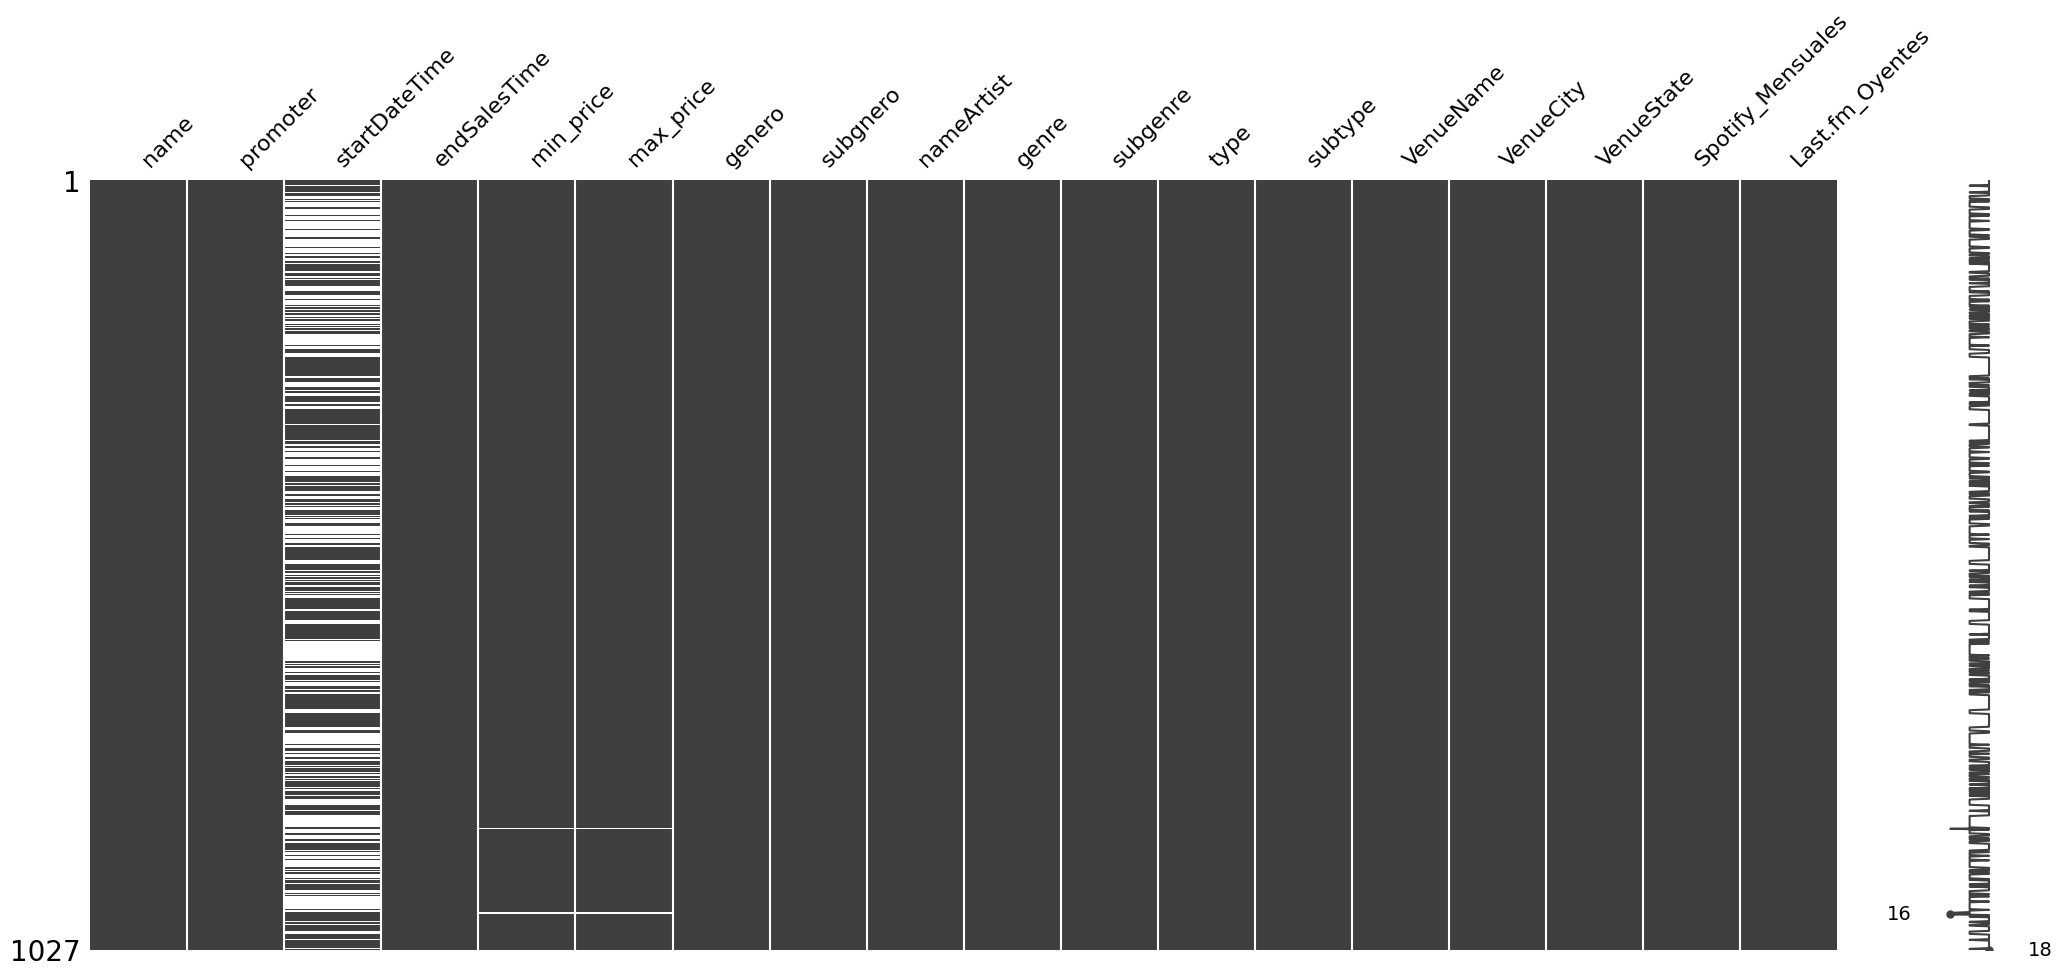

In [ ]:
import missingno as msno
msno.matrix(df4)

Parece que solo startDateTime tiene nulos.

Aparte hay 3 filas que tienen nulos también en min_price y max_price

In [ ]:
#msno.heatmap(df4)

Podemos detectar si una columna depende de otra, utilizando el test $\mathcal{X}^2$.

In [ ]:
contingencias=pd.crosstab(index=df4.startDateTime,columns=df4["min_price"])
contingencias

min_price,10.00,12.00,13.00,15.00,16.00,17.00,18.00,19.00,20.00,22.00,...,65.00,65.18,67.86,70.00,71.43,76.79,87.50,138.04,141.10,179.46
startDateTime,,,,,,,,,,,,,,,,,,,,,
2023-03-21T19:30:00Z,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-22T21:00:00Z,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-04T21:00:00Z,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-05T20:00:00Z,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-11T20:00:00Z,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-10T19:30:00Z,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-11-15T21:30:00Z,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-12-08T18:00:00Z,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Esto era para ver primero cómo se relaciona la variable objetivo con una columna nominal. Pasamos a calcular el test:

In [ ]:
from scipy.stats import chi2_contingency

# este es el test
ChiSqResult = chi2_contingency(contingencias)
ChiSqResult

Chi2ContingencyResult(statistic=24056.843104662006, pvalue=0.0, dof=10450, expected_freq=array([[0.01651376, 0.0440367 , 0.08807339, ..., 0.02201835, 0.00550459,
        0.04954128],
       [0.01651376, 0.0440367 , 0.08807339, ..., 0.02201835, 0.00550459,
        0.04954128],
       [0.01651376, 0.0440367 , 0.08807339, ..., 0.02201835, 0.00550459,
        0.04954128],
       ...,
       [0.02201835, 0.0587156 , 0.11743119, ..., 0.0293578 , 0.00733945,
        0.06605505],
       [0.02201835, 0.0587156 , 0.11743119, ..., 0.0293578 , 0.00733945,
        0.06605505],
       [0.01100917, 0.0293578 , 0.0587156 , ..., 0.0146789 , 0.00366972,
        0.03302752]]))

Como  $H_0$  = No hay correlación entre las variables, y tenemos que p!>0.05, se rechaza la hipótesis nula y se concluye que hay una asociación significativa entre las variables. \
Así, podemos probar la relación de cada variable categórica con las variables objetivos.

<Axes: xlabel='min_price', ylabel='Count'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


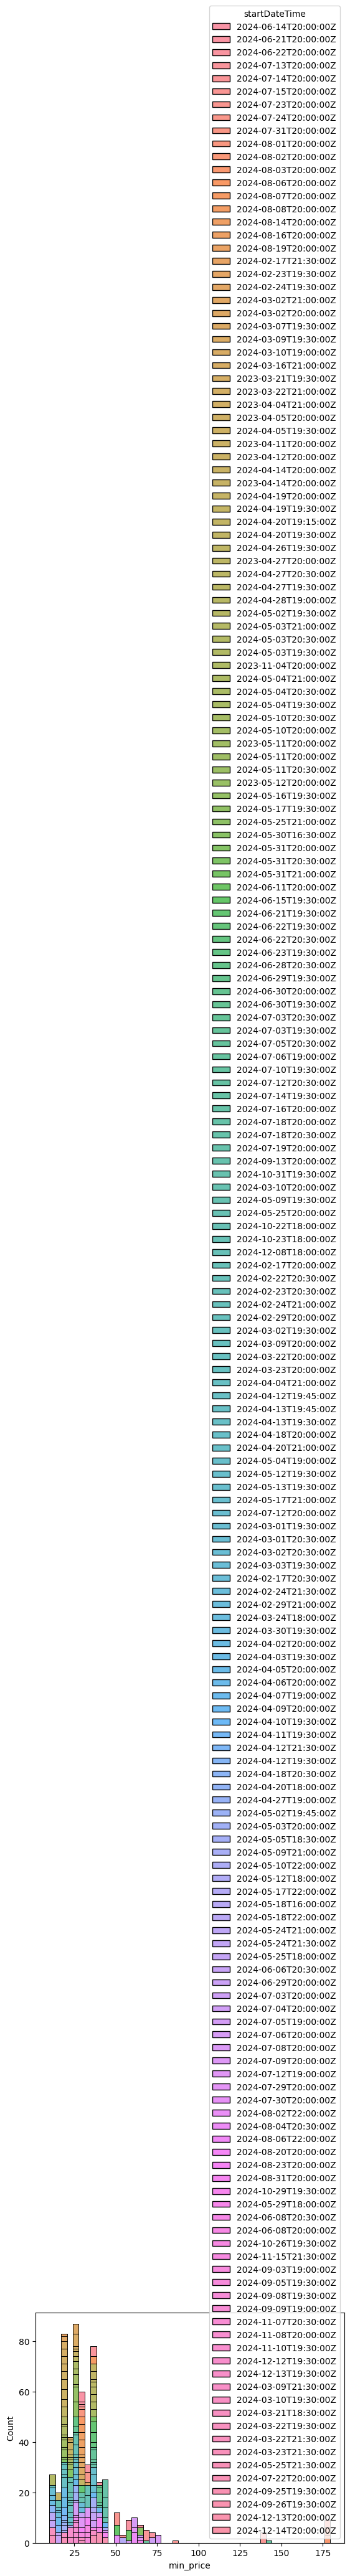

In [ ]:
sns.histplot(data=df4, hue="startDateTime",x="min_price",stat="count", multiple="stack")

PROBAR PARA NAMEARTIST

In [ ]:
contingencias=pd.crosstab(index=df4.nameArtist,columns=df4["min_price"])
contingencias

min_price,10.00,12.00,13.00,15.00,16.00,17.00,18.00,19.00,20.00,22.00,...,75.00,76.79,80.00,81.00,87.50,105.00,138.04,141.10,150.00,179.46
nameArtist,,,,,,,,,,,,,,,,,,,,,
AC/DC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0
Abraham Mateo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aitana,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aleman,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
Ana Mena,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vanesa Martín,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Víctor Martín,0,6,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Walls,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# este es el test
ChiSqResult = chi2_contingency(contingencias)
ChiSqResult

Chi2ContingencyResult(statistic=35682.62722965887, pvalue=0.0, dof=10540, expected_freq=array([[0.01171875, 0.04296875, 0.0625    , ..., 0.00390625, 0.01171875,
        0.03515625],
       [0.00878906, 0.03222656, 0.046875  , ..., 0.00292969, 0.00878906,
        0.02636719],
       [0.03222656, 0.11816406, 0.171875  , ..., 0.01074219, 0.03222656,
        0.09667969],
       ...,
       [0.0234375 , 0.0859375 , 0.125     , ..., 0.0078125 , 0.0234375 ,
        0.0703125 ],
       [0.00585938, 0.02148438, 0.03125   , ..., 0.00195312, 0.00585938,
        0.01757812],
       [0.00585938, 0.02148438, 0.03125   , ..., 0.00195312, 0.00585938,
        0.01757812]]))

<Axes: xlabel='min_price', ylabel='Count'>

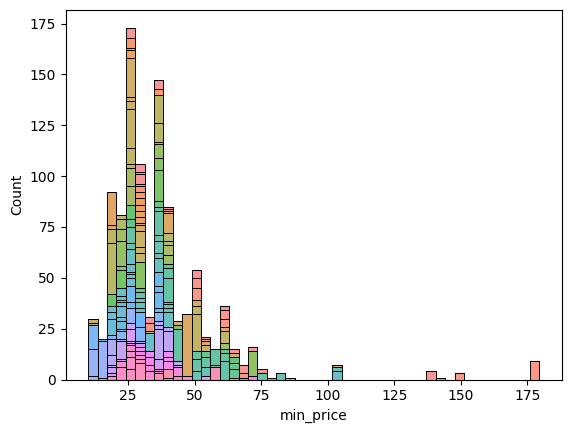

In [ ]:
sns.histplot(data=df4, hue="nameArtist",x="min_price",stat="count", multiple="stack", legend=False)